In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
from tqdm.contrib import concurrent
from multiprocessing import Pool
import itertools
import glob
from statsmodels.regression.rolling import RollingOLS

sns.set_context("paper", font_scale=1.3)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
    },
)

# Import Data

In [2]:
%%time
data_files = glob.glob("../data/returns/ticker_daily_rv/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    # Magic number for the number of observations each file should have
    if len(ticker_df) == 1447:
        ticker_dfs.append(ticker_df)

data_rv_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 2.23 s, sys: 3.52 s, total: 5.75 s
Wall time: 4.43 s


In [3]:
%%time
data_files = glob.glob("../data/prices/tickers_clean/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    ticker_dfs.append(ticker_df)

data_prices_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 7.52 s, sys: 22.2 s, total: 29.7 s
Wall time: 31.9 s


# Data Prep

In [4]:
# Ticker lists
faang_tickers = ['AAPL', 'AMZN', 'GOOG', 'NFLX', 'FB']

In [5]:
%%time
# Daily prices
data_prices_daily_df = data_prices_df.groupby(['ticker', 'date'])['price'].last().reset_index()

# Indexed prices
data_prices_daily_df['first_price'] = data_prices_daily_df.groupby(['ticker'])['price'].transform('first')
data_prices_daily_df['price_idx'] = 100*data_prices_daily_df['price']/data_prices_daily_df['first_price']

CPU times: user 3.88 s, sys: 4.58 s, total: 8.45 s
Wall time: 8.53 s


## Rolling Beta

In [6]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [7]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

In [8]:
%%time
# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers, chunksize=30),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_beta_df = pd.concat(results)


CPU times: user 844 ms, sys: 5.53 s, total: 6.38 s
Wall time: 58.1 s


In [9]:
## Not idempotent 
coeff_cols = ["rv_lag_1", "rv_lag_m5", "rv_lag_m22"]
data_rv_df = data_rv_df.merge(
    rolling_beta_df.rename(columns={x: (x + "_rollcoeff") for x in coeff_cols}).drop(
        "Intercept", axis=1
    ),
    on=["date", "ticker"],
    how="left",
)
data_rv_df["persistence"] = (
    data_rv_df["rv_lag_1_rollcoeff"]
    + data_rv_df["rv_lag_m5_rollcoeff"]
    + data_rv_df["rv_lag_m22_rollcoeff"]
)

# Summary Plots

## Data Summary

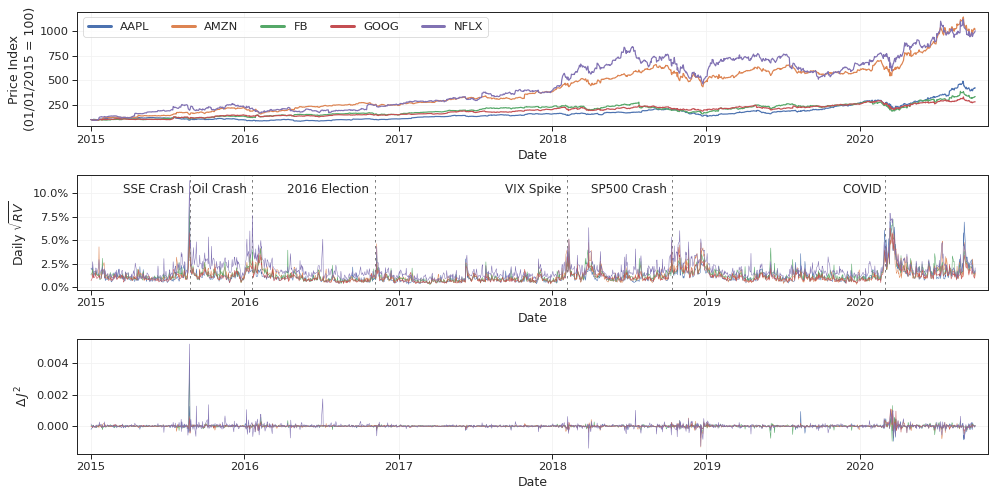

In [50]:
fig, axs = plt.subplots(figsize=(14, 7), nrows=3)
palette = sns.color_palette("deep", 5)
tickers = faang_tickers


## Event labels, dashed lines
for ax in [axs[1]]:
    ax.axvline(pd.to_datetime("2015-08-24"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2016-01-20"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    
axs[1].text(pd.to_datetime("2015-08-20"), 0.1, 'SSE Crash ', fontsize = 12, ha = 'right')
axs[1].text(pd.to_datetime("2016-01-16"), 0.1, 'Oil Crash ', fontsize = 12, ha = 'right')
axs[1].text(pd.to_datetime("2016-11-01"), 0.1, '2016 Election ', fontsize = 12, ha = 'right')
axs[1].text(pd.to_datetime("2018-02-01"), 0.1, 'VIX Spike ', fontsize = 12, ha = 'right')
axs[1].text(pd.to_datetime("2018-10-08"), 0.1, 'SP500 Crash ', fontsize = 12, ha = 'right')
axs[1].text(pd.to_datetime("2020-03-01"), 0.1, 'COVID ', fontsize = 12, ha = 'right')


## Indexed prices
ax = axs[0]
sns.lineplot(
    x="date",
    y="price_idx",
    hue = 'ticker',
    palette = palette,
    data=data_prices_daily_df.query("ticker in @tickers"),
    ax=ax,
)
ax.set_xlabel('Date')
ax.set_ylabel('Price Index\n(01/01/2015 = 100)')
ax.legend(ncol = len(tickers))
for legobj in ax.get_legend().legendHandles:
    legobj.set_linewidth(3)

## Realized Volatility
ax = axs[1]
data_rv_df["rvol"] = np.sqrt(data_rv_df["rv"])
sns.lineplot(
    x="date",
    y="rvol",
    hue="ticker",
    palette="deep",
    lw=0.5,
    data=data_rv_df.query("ticker in @tickers"),
    ax=ax,
)
ax.set_xlabel("Date")
ax.set_ylabel("Daily $\\sqrt{RV}$")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
ax.get_legend().remove()

## Sum of Squared Jumps
ax = axs[2]
sns.lineplot(
    x="date",
    y="sgn_jump_var",
    hue="ticker",
    palette="deep",
    lw=0.5,
    data=data_rv_df.query(f"ticker in @tickers"),
    ax = ax
)
ax.set_xlabel('Date')
ax.set_ylabel('$\\Delta \, J^2$')
ax.get_legend().remove()



## All ax modifiers
for ax in axs:
    ax.set_xlim(pd.to_datetime('2014-12-01'), pd.to_datetime('2020-10-31'))

plt.tight_layout()
plt.savefig('../exhibits/final_paper/faang_data_summary.pdf')

## Persistence

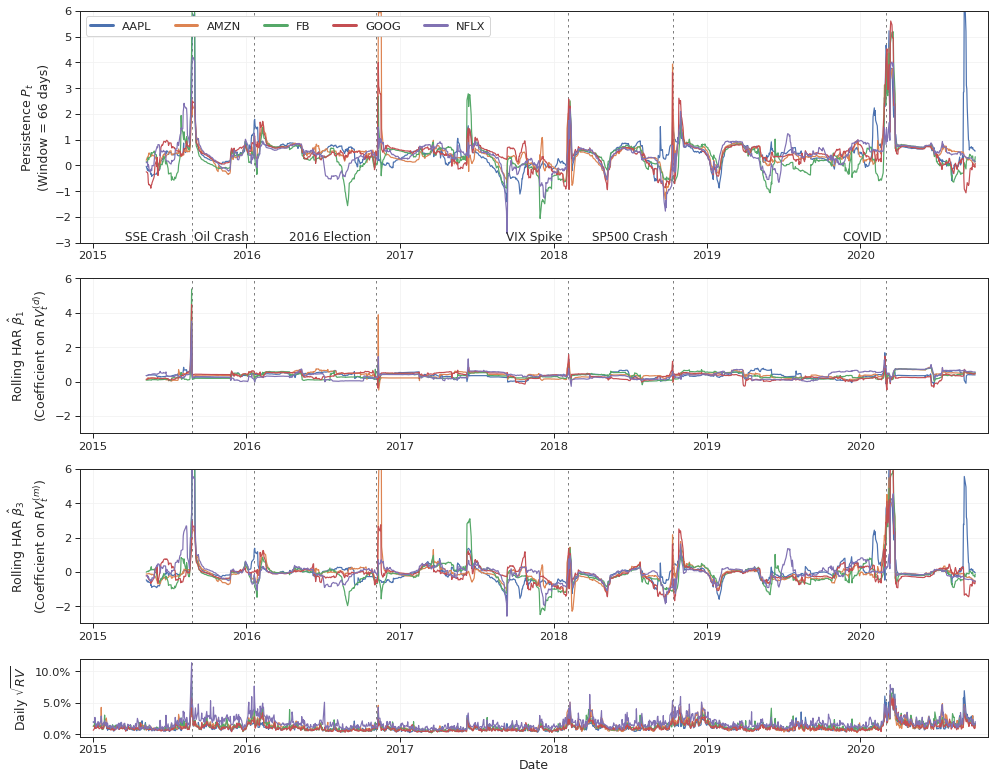

In [49]:
fig, axs = plt.subplots(
    figsize=(14, 11), nrows=4, gridspec_kw={"height_ratios": [3, 2, 2, 1]}
)
ticker_subset = ["FB", "AAPL", "AMZN", "NFLX", "GOOG"]


## Event labels, dashed lines
for ax in axs.reshape(-1):
    ax.axvline(pd.to_datetime("2015-08-24"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2016-01-20"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    
axs[0].text(pd.to_datetime("2015-08-20"), -2.9, 'SSE Crash ', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2016-01-16"), -2.9, 'Oil Crash ', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2016-11-01"), -2.9, '2016 Election ', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2018-02-01"), -2.9, 'VIX Spike ', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2018-10-08"), -2.9, 'SP500 Crash ', fontsize = 12, ha = 'right')
axs[0].text(pd.to_datetime("2020-03-01"), -2.9, 'COVID ', fontsize = 12, ha = 'right')

    
## Rolling Persistence
ax = axs[0]
sns.lineplot(
    x="date",
    y="persistence",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("")
ax.set_ylabel("Persistence $P_t$\n(Window = " + f"{window} days)")
ax.set_ylim(-3,6)
ax.legend(ncol=5, loc = 'upper left', framealpha = 0.999)
leg = ax.get_legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(3)
    
## Rolling Beta_1
ax = axs[1]
sns.lineplot(
    x="date",
    y="rv_lag_1_rollcoeff",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("")
ax.set_ylabel("Rolling HAR $\\hat{\\beta}_1$\n(Coefficient on $RV_t^{(d)}$)")
ax.set_ylim(-3,6)
ax.get_legend().remove()

## Rolling Beta_3
ax = axs[2]
sns.lineplot(
    x="date",
    y="rv_lag_m22_rollcoeff",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("")
ax.set_ylabel("Rolling HAR $\\hat{\\beta}_3$\n(Coefficient on $RV_t^{(m)}$)")
ax.set_ylim(-3,6)
ax.get_legend().remove()

## Realized Volatility
ax = axs[3]
data_rv_df["rvol"] = np.sqrt(data_rv_df["rv"])
sns.lineplot(
    x="date",
    y="rvol",
    hue="ticker",
    palette="deep",
    lw=1.2,
    data=data_rv_df.query("ticker in @ticker_subset"),
    ax=ax,
)
ax.set_xlabel("Date")
ax.set_ylabel("Daily $\\sqrt{RV}$")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
ax.get_legend().remove()

## All ax modifiers
for ax in axs:
    ax.set_xlim(pd.to_datetime('2014-12-01'), pd.to_datetime('2020-10-31'))

plt.tight_layout()
plt.savefig(f"../exhibits/final_paper/faang_persistence.pdf")

## Persistence and Crisis Index Example

In [12]:
data_rv_df["indicator_high_beta"] = data_rv_df["persistence"] > 0.6
data_rv_df["crisis_index"] = (
    data_rv_df.groupby("ticker")["indicator_high_beta"]
    .rolling(22)
    .mean()
    .reset_index(drop=True)
)

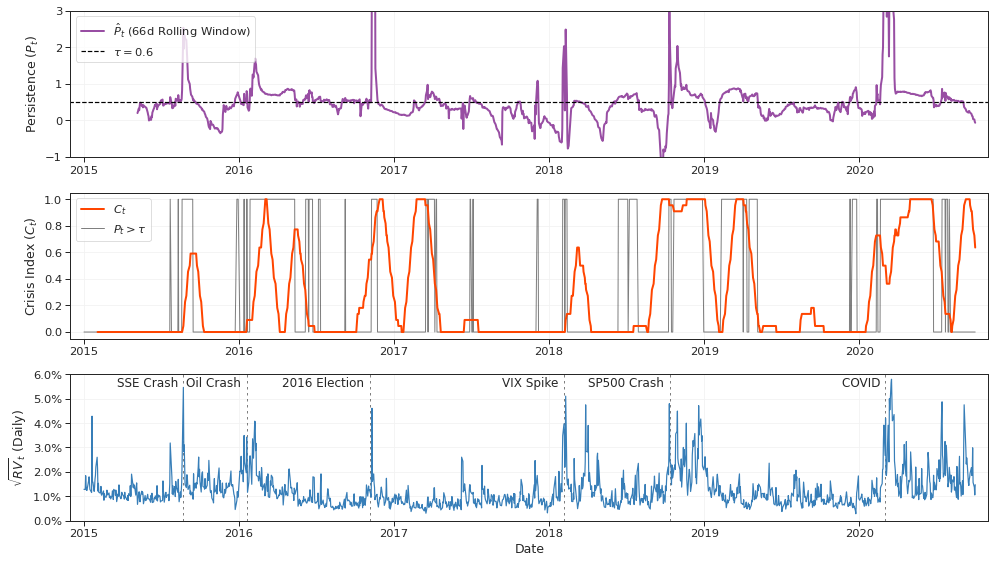

In [48]:
fig, axs = plt.subplots(
    nrows=3, figsize=(14, 8), gridspec_kw={"height_ratios": [2, 2, 2]}
)
ticker = "AMZN"
pal = sns.color_palette("Set1", 10)


## Event labels, dashed lines
for ax in [axs[-1]]:
    ax.axvline(pd.to_datetime("2015-08-24"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2016-01-20"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2016-11-05"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-02-05"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2018-10-12"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    ax.axvline(pd.to_datetime("2020-03-01"), 0, 1, lw = 0.5, ls=(0, (5, 7)), color="black")
    
axs[-1].text(pd.to_datetime("2015-08-20"), 0.055, 'SSE Crash ', fontsize = 12, ha = 'right')
axs[-1].text(pd.to_datetime("2016-01-16"), 0.055, 'Oil Crash ', fontsize = 12, ha = 'right')
axs[-1].text(pd.to_datetime("2016-11-01"), 0.055, '2016 Election ', fontsize = 12, ha = 'right')
axs[-1].text(pd.to_datetime("2018-02-01"), 0.055, 'VIX Spike ', fontsize = 12, ha = 'right')
axs[-1].text(pd.to_datetime("2018-10-08"), 0.055, 'SP500 Crash ', fontsize = 12, ha = 'right')
axs[-1].text(pd.to_datetime("2020-03-01"), 0.055, 'COVID ', fontsize = 12, ha = 'right')


## Persistence
ax = axs[0]
sns.lineplot(
    x="date",
    y="persistence",
    color=pal[3],
    label="$\hat{P}_t$ (66d Rolling Window)",
    lw=2,
    data=data_rv_df.query("ticker == @ticker"),
    ax=ax,
)
ax.axhline(0.5, -1, 1, color="k", ls="dashed", label="$\\tau = 0.6$")
ax.set_ylim(-1, 3)
ax.set_xlabel("")
ax.set_ylabel("Persistence ($P_t$)")
ax.legend(loc="upper left")

## High Persistence Indicator and Crisis Index
ax = axs[1]
sns.lineplot(
    x="date",
    y="crisis_index",
    label="$C_t$",
    color='orangered',
    lw = 2,
    data=data_rv_df.query("ticker == @ticker"),
    ax=ax,
    **{'zorder':99}
)
sns.lineplot(
    x="date",
    y="indicator_high_beta",
    label="$P_t > \\tau$",
    lw = 1,
    color="k",
    alpha = 0.5,
    data=data_rv_df.query("ticker == @ticker"),
    ax=ax
)
ax.legend()
ax.set_xlabel("")
ax.set_ylabel("Crisis Index ($C_t$)")

## Realized Volatility
ax = axs[2]
sns.lineplot(
    x="date", y="rvol", color=pal[1], data=data_rv_df.query("ticker == @ticker"), ax=ax
)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
ax.axhline(0.5, -1, 1, color="k", ls="dashed")
ax.set_ylim(0, 0.06)
ax.set_ylabel("$\sqrt{RV}_t$ (Daily)")
ax.set_xlabel("Date")

####
for ax in axs.reshape(-1):
    ax.set_xlim(pd.to_datetime('2014-12-01'), pd.to_datetime('2020-10-31'))

plt.tight_layout()
plt.savefig('../exhibits/final_paper/crisis_index_example.pdf')